Running experiments by H: 100%|██████████| 9/9 [00:49<00:00,  5.55s/it]


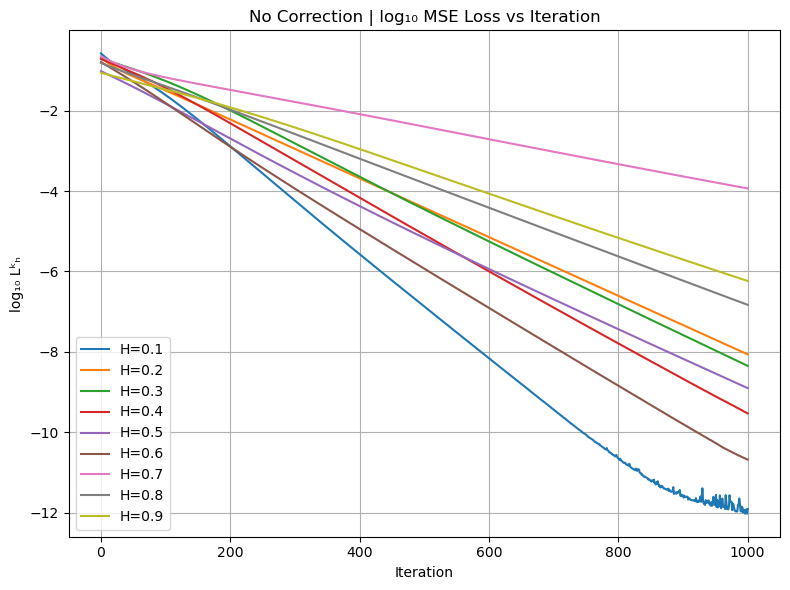

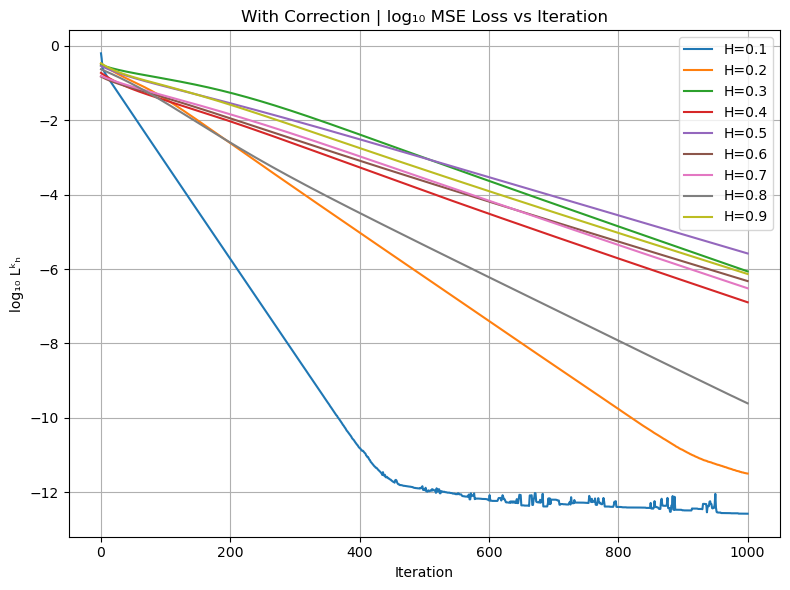

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta*np.sqrt(n))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift

        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out = out + correction

        return x + out

class FBMResNet(nn.Module):
    def __init__(self, n, num_layers, beta, W_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(n, n)
        self.output_layer = nn.Linear(n, n)
        self.L = num_layers

        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)


class SingleDatumLoader:
    def __init__(self, x, y, batch_size=1):
        self.x = x.unsqueeze(0).repeat(batch_size, 1)
        self.y = y.unsqueeze(0).repeat(batch_size, 1)

    def __iter__(self):
        while True:
            yield self.x, self.y


def train_single_point_model(model, loader, epochs=1000, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []

    for i, (x_batch, y_batch) in enumerate(loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i >= epochs:
            break

    return train_losses


def plot_onepoint_loss_curves(loss_dict, label_prefix):
    plt.figure(figsize=(8, 6))
    for H, losses in sorted(loss_dict.items()):
        log_losses = np.log10(losses)
        plt.plot(log_losses, label=f"H={H:.1f}")
    plt.title(f"{label_prefix} | log₁₀ MSE Loss vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("log₁₀ Lᵏₕ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
L = 100
n = 10
epochs = 1000

# Fixed one data point
x = torch.randn(n).to(device)
y = torch.randn(n).to(device)
loader = SingleDatumLoader(x/(np.sqrt(n)), y/(np.sqrt(n)), batch_size=1)

# Containers
train_losses_corr = {}
train_losses_nocorr = {}

# Run both variants
for H in tqdm(selected_H, desc="Running experiments by H"):
    W_tensor = generate_fbm_weight_tensor(L, n, H=H)

    model_nocorr = FBMResNet(n=n, num_layers=L, beta=H, W_tensor=W_tensor, apply_correction=False)
    train_losses_nocorr[H] = train_single_point_model(model_nocorr, loader, epochs=epochs, lr=0.1*n/L)

    model_corr = FBMResNet(n=n, num_layers=L, beta=H, W_tensor=W_tensor, apply_correction=True)
    train_losses_corr[H] = train_single_point_model(model_corr, loader, epochs=epochs, lr=0.1*n/L)

# Plot both
plot_onepoint_loss_curves(train_losses_nocorr, "No Correction")
plot_onepoint_loss_curves(train_losses_corr, "With Correction")


Averaging over runs: 100%|██████████| 50/50 [19:51<00:00, 23.83s/it]


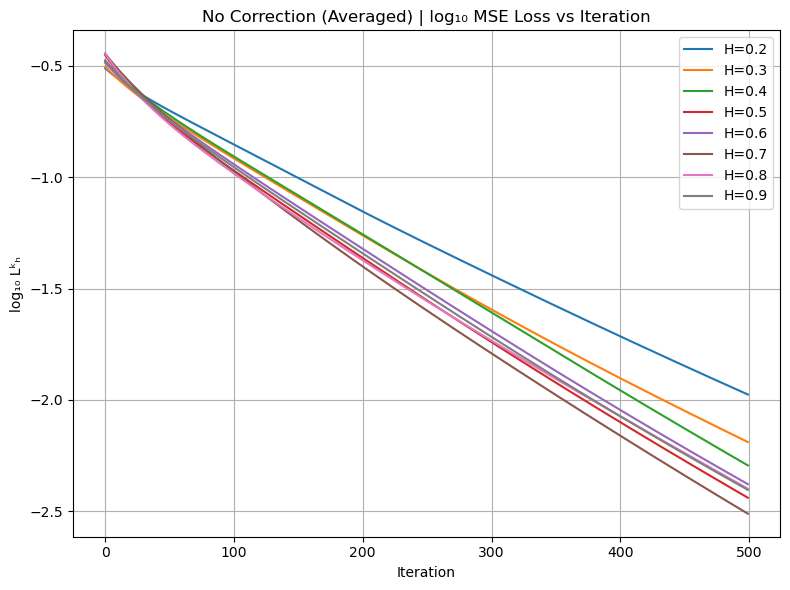

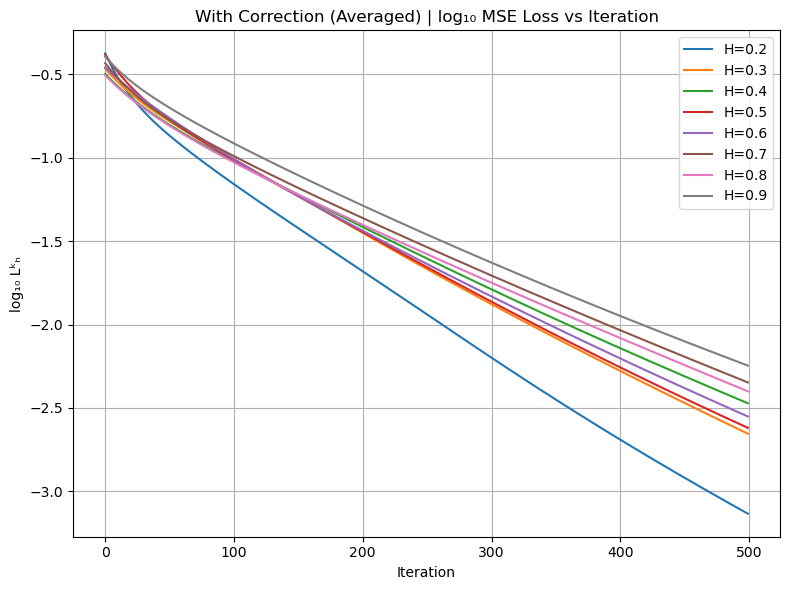

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta*np.sqrt(n))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift

        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out = out + correction

        return x + out

class FBMResNet(nn.Module):
    def __init__(self, n, num_layers, beta, W_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(n, n)
        self.output_layer = nn.Linear(n, n)
        self.L = num_layers

        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)


class SingleDatumLoader:
    def __init__(self, x, y, batch_size=1):
        self.x = x.unsqueeze(0).repeat(batch_size, 1)
        self.y = y.unsqueeze(0).repeat(batch_size, 1)

    def __iter__(self):
        while True:
            yield self.x, self.y


def train_single_point_model(model, loader, epochs=1000, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []

    for i, (x_batch, y_batch) in enumerate(loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i >= epochs-1:
            break

    return train_losses


def plot_onepoint_loss_curves(loss_dict, label_prefix):
    plt.figure(figsize=(8, 6))
    for H, losses in sorted(loss_dict.items()):
        log_losses = np.log10(losses)
        plt.plot(log_losses, label=f"H={H:.1f}")
    plt.title(f"{label_prefix} | log₁₀ MSE Loss vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("log₁₀ Lᵏₕ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
L = 100
n = 5
epochs = 500

n_runs = 50  # Number of runs for averaging
train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}

for run in tqdm(range(n_runs), desc="Averaging over runs"):
    x = torch.randn(n).to(device)
    y = torch.randn(n).to(device)
    loader = SingleDatumLoader(x / np.sqrt(n), y / np.sqrt(n), batch_size=1)

    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)

        # No correction
        model_nocorr = FBMResNet(n=n, num_layers=L, beta=H, W_tensor=W_tensor, apply_correction=False)
        losses_nocorr = train_single_point_model(model_nocorr, loader, epochs=epochs, lr=0.1 * n / L)
        train_losses_nocorr[H] += np.array(losses_nocorr)

        # With correction
        model_corr = FBMResNet(n=n, num_layers=L, beta=H, W_tensor=W_tensor, apply_correction=True)
        losses_corr = train_single_point_model(model_corr, loader, epochs=epochs, lr=0.1 * n / L)
        train_losses_corr[H] += np.array(losses_corr)

# Average losses
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs

# Plotting
plot_onepoint_loss_curves(train_losses_nocorr, "No Correction (Averaged)")
plot_onepoint_loss_curves(train_losses_corr, "With Correction (Averaged)")



Averaging over runs: 100%|██████████| 50/50 [20:51<00:00, 25.04s/it]


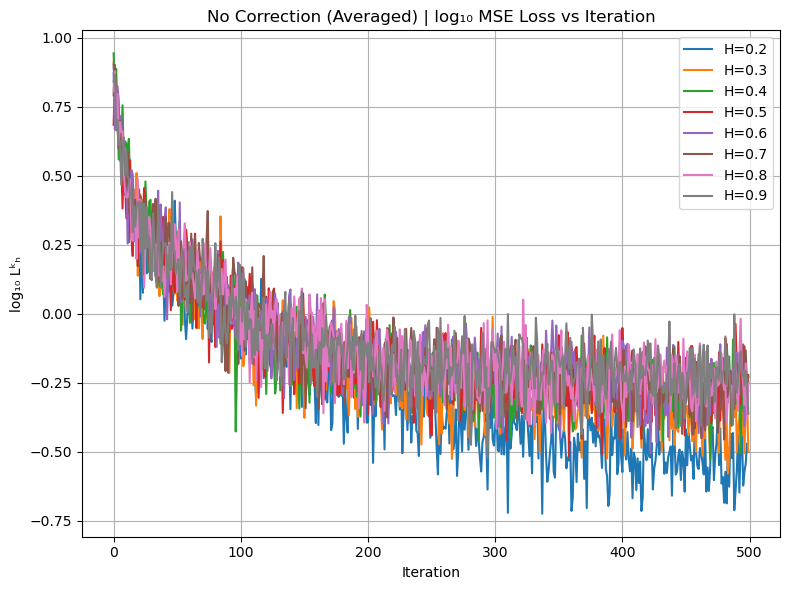

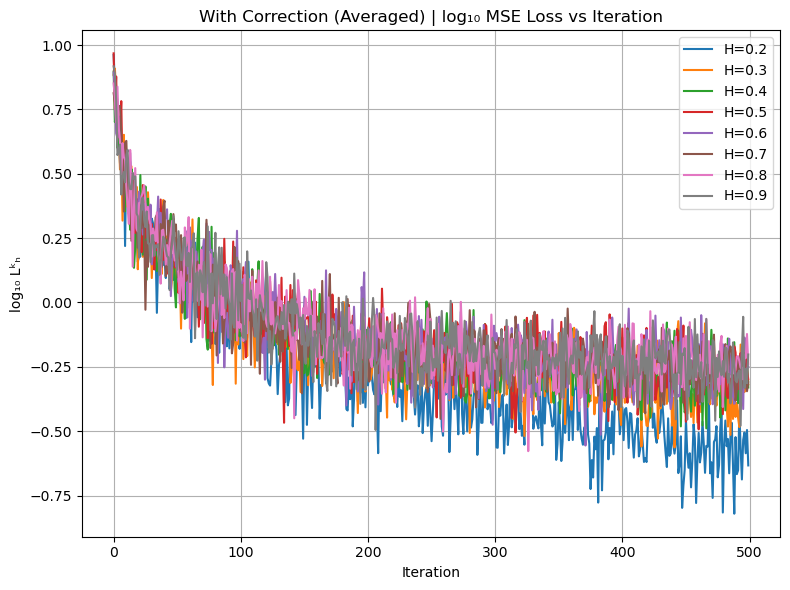

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== Synthetic Data (Scagliotti-style) ==========
def generate_transformed_dataset():
    x1_vals = np.linspace(0, 2, 50)
    x2_vals = np.linspace(-0.9, 0.9, 50)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()

    def psi(x1, x2):
        return np.exp(x1) * np.cos(x2), np.exp(x1) * np.sin(x2)

    Y1, Y2 = psi(X1_flat, X2_flat)

    X_np = np.stack([X1_flat, X2_flat], axis=1)
    Y_np = np.stack([Y1, Y2], axis=1)

    X = torch.tensor(X_np, dtype=torch.float32)
    Y = torch.tensor(Y_np, dtype=torch.float32)

    return X, Y

class TransformedDatasetLoader:
    def __init__(self, X, Y, batch_size=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            idx = torch.randint(0, self.X.shape[0], (self.batch_size,))
            yield self.X[idx], self.Y[idx]

# ========== FBM Weight Generator ==========
def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

# ========== FBM ResNet ==========
class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta * np.sqrt(W_k.size(0)))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift

        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out = out + correction

        return x + out

class FBMResNet(nn.Module):
    def __init__(self, input_dim, n, num_layers, beta, W_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, n)
        self.output_layer = nn.Linear(n, input_dim)
        self.L = num_layers

        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

# ========== Training ==========
def train_single_point_model(model, loader, epochs=1000, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []

    for i, (x_batch, y_batch) in enumerate(loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i >= epochs - 1:
            break

    return train_losses

# ========== Plotting ==========
def plot_onepoint_loss_curves(loss_dict, label_prefix):
    plt.figure(figsize=(8, 6))
    for H, losses in sorted(loss_dict.items()):
        log_losses = np.log10(losses)
        plt.plot(log_losses, label=f"H={H:.1f}")
    plt.title(f"{label_prefix} | log₁₀ MSE Loss vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("log₁₀ Lᵏₕ")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ========== Experiment ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
L = 100
n = 10  # Must match dimension of synthetic data
epochs = 500
n_runs = 50

train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}

# Load synthetic dataset
X, Y = generate_transformed_dataset()
loader = TransformedDatasetLoader(X.to(device), Y.to(device), batch_size=1)

for run in tqdm(range(n_runs), desc="Averaging over runs"):
    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)

        # No correction
        model_nocorr = FBMResNet(input_dim=2,n=n, num_layers=L, beta=H, W_tensor=W_tensor, apply_correction=False)
        losses_nocorr = train_single_point_model(model_nocorr, loader, epochs=epochs, lr=0.1 * n / L)
        train_losses_nocorr[H] += np.array(losses_nocorr)

        # With correction
        model_corr = FBMResNet(input_dim=2,n=n, num_layers=L, beta=H, W_tensor=W_tensor, apply_correction=True)
        losses_corr = train_single_point_model(model_corr, loader, epochs=epochs, lr=0.1 * n / L)
        train_losses_corr[H] += np.array(losses_corr)

# Average
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs

# Plot
plot_onepoint_loss_curves(train_losses_nocorr, "No Correction (Averaged)")
plot_onepoint_loss_curves(train_losses_corr, "With Correction (Averaged)")


Averaging over runs: 100%|██████████| 50/50 [59:23<00:00, 71.26s/it] 


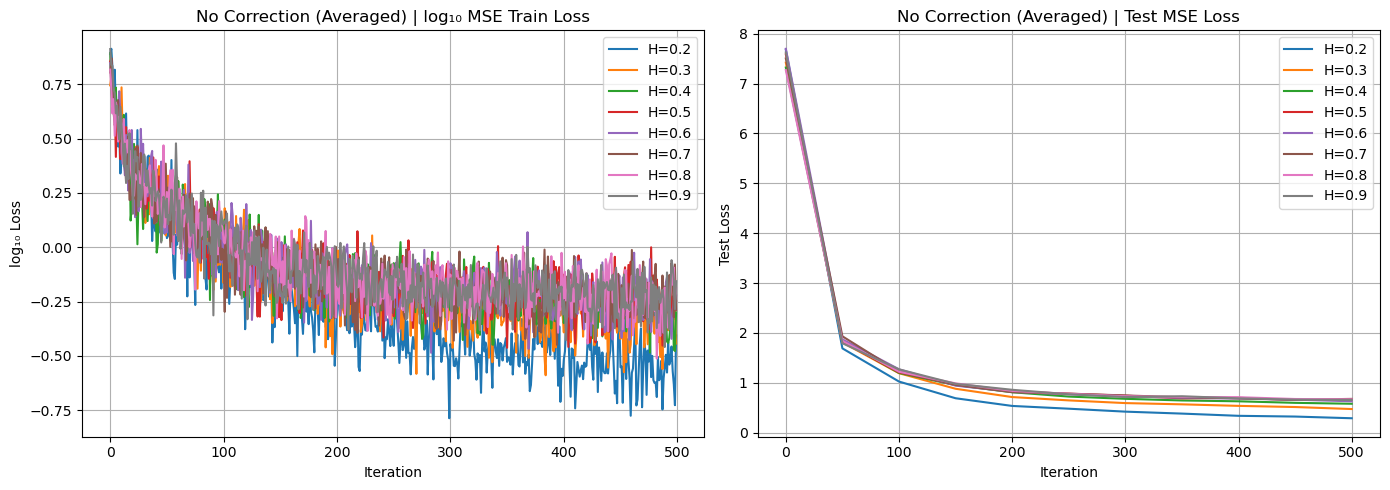

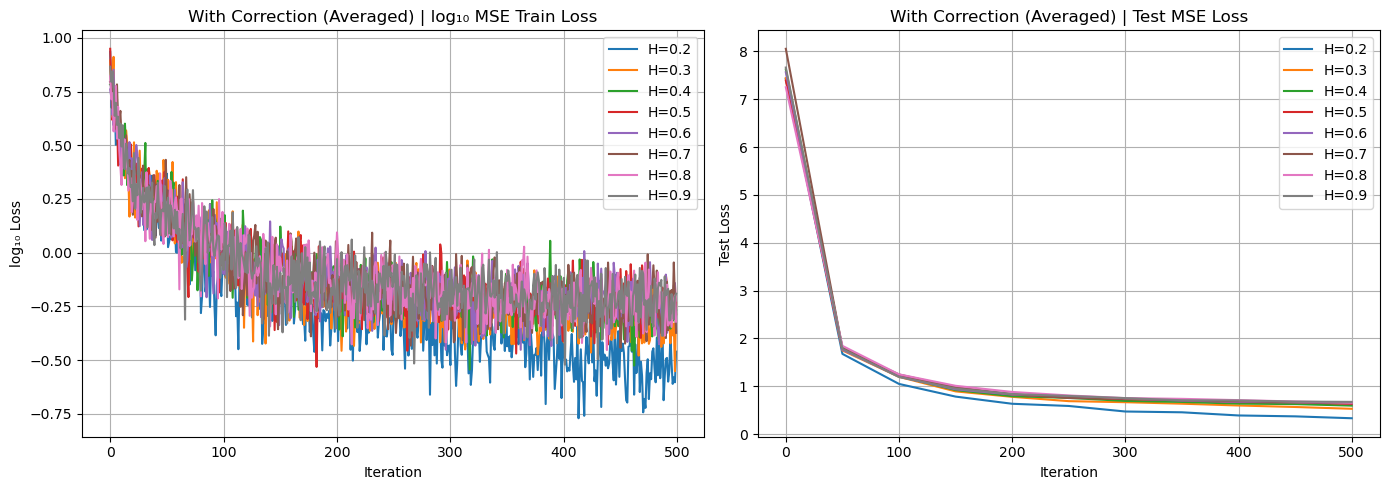

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== Synthetic Data (Scagliotti-style) ==========
def generate_transformed_dataset():
    x1_vals = np.linspace(0, 2, 30)  # reduced from 50 to save memory
    x2_vals = np.linspace(-0.9, 0.9, 30)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()

    def psi(x1, x2):
        return np.exp(x1) * np.cos(x2), np.exp(x1) * np.sin(x2)

    Y1, Y2 = psi(X1_flat, X2_flat)

    X_np = np.stack([X1_flat, X2_flat], axis=1)
    Y_np = np.stack([Y1, Y2], axis=1)

    X = torch.tensor(X_np, dtype=torch.float32)
    Y = torch.tensor(Y_np, dtype=torch.float32)

    return X, Y

class TransformedDatasetLoader:
    def __init__(self, X, Y, batch_size=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            idx = torch.randint(0, self.X.shape[0], (self.batch_size,))
            yield self.X[idx], self.Y[idx]

# ========== FBM Generator ==========
def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

# ========== FBM ResNet ==========
class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta * np.sqrt(W_k.size(0)))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift

        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out = out + correction

        return x + out

class FBMResNet(nn.Module):
    def __init__(self, input_dim, n, num_layers, beta, W_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, n)
        self.output_layer = nn.Linear(n, input_dim)
        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

# ========== Evaluation ==========
@torch.no_grad()
def evaluate_on_test(model, test_loader, criterion, max_batches=200):
    model.eval()
    total_loss = 0.0
    num_samples = 0

    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i >= max_batches:
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)
        num_samples += x_batch.size(0)

    return total_loss / num_samples

# ========== Training ==========
def train_single_point_model(model, train_loader, test_loader, epochs=300, lr=0.01, log_interval=50):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i % log_interval == 0 or i == epochs - 1:
            test_loss = evaluate_on_test(model, test_loader, criterion)
            test_losses.append(test_loss)

        if i >= epochs - 1:
            break

    return train_losses, test_losses

# ========== Plotting ==========
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Train Loss
    for H, losses in sorted(train_loss_dict.items()):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Test Loss
    for H, losses in sorted(test_loss_dict.items()):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ========== Experiment ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9,0.8, 0.7,0.6, 0.5,0.4, 0.3,0.2]
L = 100
n = 10
epochs = 500
log_interval = 50
n_runs = 50

train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}
test_losses_corr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
test_losses_nocorr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}

# Dataset
X, Y = generate_transformed_dataset()
perm = torch.randperm(X.size(0))
X_train, Y_train = X[perm[:800]], Y[perm[:800]]
X_test, Y_test = X[perm[800:]], Y[perm[800:]]

train_loader = TransformedDatasetLoader(X_train.to(device), Y_train.to(device), batch_size=1)
test_loader = TransformedDatasetLoader(X_test.to(device), Y_test.to(device), batch_size=64)

# Main loop
for run in tqdm(range(n_runs), desc="Averaging over runs"):
    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)

        # No correction
        model_nocorr = FBMResNet(2, n, L, H, W_tensor, apply_correction=False)
        losses_nocorr, test_nocorr = train_single_point_model(model_nocorr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_nocorr[H] += np.array(losses_nocorr)
        test_losses_nocorr[H] += np.array(test_nocorr)

        # With correction
        model_corr = FBMResNet(2, n, L, H, W_tensor, apply_correction=True)
        losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_corr[H] += np.array(losses_corr)
        test_losses_corr[H] += np.array(test_corr)

# Average
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    test_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs
    test_losses_corr[H] /= n_runs

# Plot
plot_loss_curves(train_losses_nocorr, test_losses_nocorr, "No Correction (Averaged)", log_interval)
plot_loss_curves(train_losses_corr, test_losses_corr, "With Correction (Averaged)", log_interval)


Averaging over runs: 100%|██████████| 1/1 [10:02<00:00, 602.62s/it]


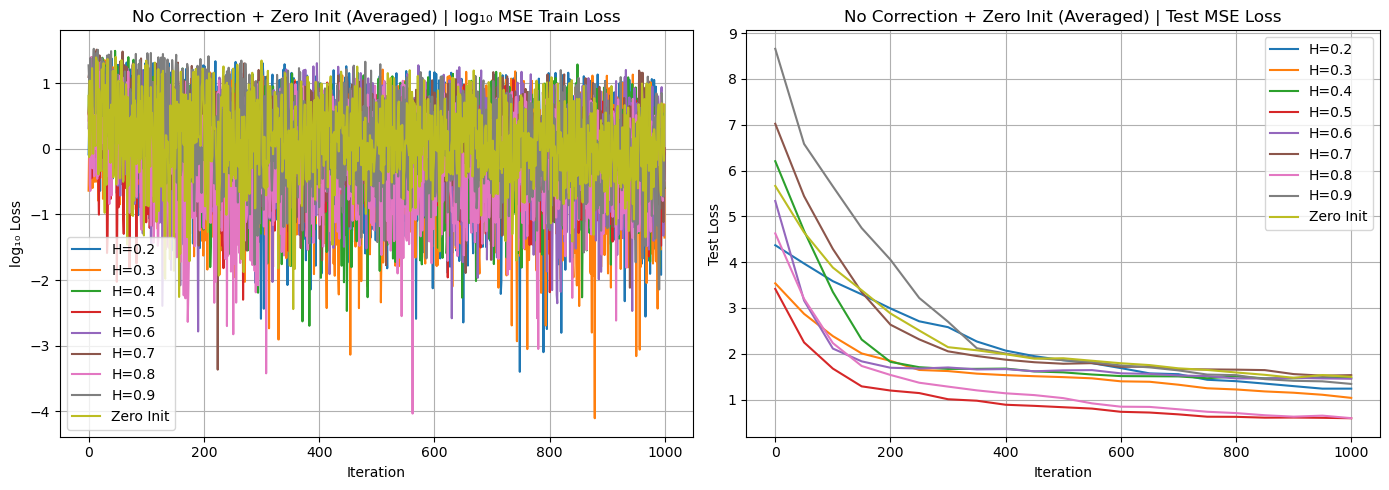

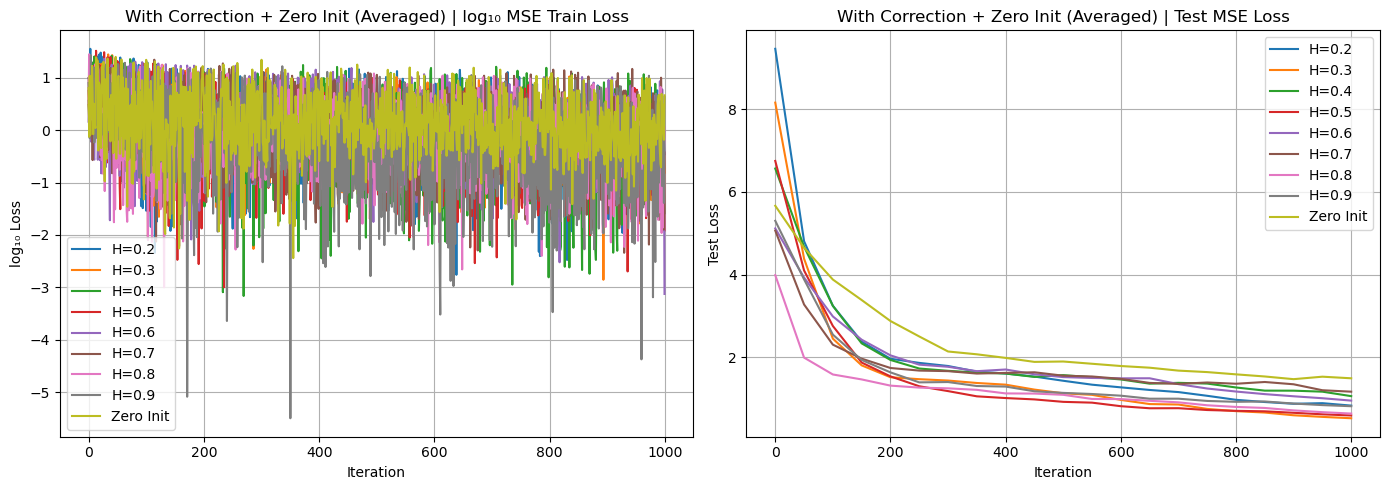

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== Synthetic Data ==========
def generate_transformed_dataset():
    x1_vals = np.linspace(0, 2, 30)
    x2_vals = np.linspace(-0.9, 0.9, 30)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()

    def psi(x1, x2):
        return np.exp(x1) * np.cos(x2), np.exp(x1) * np.sin(x2)

    Y1, Y2 = psi(X1_flat, X2_flat)
    X_np = np.stack([X1_flat, X2_flat], axis=1)
    Y_np = np.stack([Y1, Y2], axis=1)

    X = torch.tensor(X_np, dtype=torch.float32)
    Y = torch.tensor(Y_np, dtype=torch.float32)
    return X, Y

class TransformedDatasetLoader:
    def __init__(self, X, Y, batch_size=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            idx = torch.randint(0, self.X.shape[0], (self.batch_size,))
            yield self.X[idx], self.Y[idx]

# ========== FBM Generator ==========
def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

def generate_zero_weight_tensor(L, n):
    return torch.zeros((L, n, n), dtype=torch.float32)

# ========== FBM ResNet ==========
class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta * np.sqrt(W_k.size(0)))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift
        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out += correction
        return x + out

class FBMResNet(nn.Module):
    def __init__(self, input_dim, n, num_layers, beta, W_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, n)
        self.output_layer = nn.Linear(n, input_dim)
        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

# ========== Evaluation ==========
@torch.no_grad()
def evaluate_on_test(model, test_loader, criterion, max_batches=200):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i >= max_batches:
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)
        num_samples += x_batch.size(0)
    return total_loss / num_samples

# ========== Training ==========
def train_single_point_model(model, train_loader, test_loader, epochs=300, lr=0.01, log_interval=50):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i % log_interval == 0 or i == epochs - 1:
            test_loss = evaluate_on_test(model, test_loader, criterion)
            test_losses.append(test_loss)

        if i >= epochs - 1:
            break
    return train_losses, test_losses

# ========== Plotting ==========
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for H, losses in sorted(train_loss_dict.items(), key=lambda x: str(x[0])):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].legend()
    axes[0].grid(True)

    for H, losses in sorted(test_loss_dict.items(), key=lambda x: str(x[0])):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ========== Experiment ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
L = 500
n = 5
epochs = 1000
log_interval = 50
n_runs = 1

train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}
test_losses_corr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
test_losses_nocorr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
train_losses_zero = {"zero": np.zeros(epochs)}
test_losses_zero = {"zero": np.zeros(epochs // log_interval + 1)}

# Dataset
X, Y = generate_transformed_dataset()
perm = torch.randperm(X.size(0))
X_train, Y_train = X[perm[:800]], Y[perm[:800]]
X_test, Y_test = X[perm[800:]], Y[perm[800:]]

train_loader = TransformedDatasetLoader(X_train.to(device), Y_train.to(device), batch_size=1)
test_loader = TransformedDatasetLoader(X_test.to(device), Y_test.to(device), batch_size=64)

# Main loop
for run in tqdm(range(n_runs), desc="Averaging over runs"):
    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)

        # No correction
        model_nocorr = FBMResNet(2, n, L, H, W_tensor, apply_correction=False)
        losses_nocorr, test_nocorr = train_single_point_model(model_nocorr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_nocorr[H] += np.array(losses_nocorr)
        test_losses_nocorr[H] += np.array(test_nocorr)

        # With correction
        model_corr = FBMResNet(2, n, L, H, W_tensor, apply_correction=True)
        losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_corr[H] += np.array(losses_corr)
        test_losses_corr[H] += np.array(test_corr)

    # === Zero Init ===
    W_tensor_zero = generate_zero_weight_tensor(L, n)
    model_zero = FBMResNet(2, n, L, beta=0.5, W_tensor=W_tensor_zero, apply_correction=False)
    losses_zero, test_zero = train_single_point_model(model_zero, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
    train_losses_zero["zero"] += np.array(losses_zero)
    test_losses_zero["zero"] += np.array(test_zero)

# Average
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    test_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs
    test_losses_corr[H] /= n_runs

train_losses_zero["zero"] /= n_runs
test_losses_zero["zero"] /= n_runs

# Plot
plot_loss_curves({**train_losses_nocorr, **train_losses_zero},
                 {**test_losses_nocorr, **test_losses_zero},
                 "No Correction + Zero Init (Averaged)", log_interval)

plot_loss_curves({**train_losses_corr, **train_losses_zero},
                 {**test_losses_corr, **test_losses_zero},
                 "With Correction + Zero Init (Averaged)", log_interval)

In [3]:
def plot_diffeomorphism_comparison(model, X_train, Y_train, X_test, Y_test, train_loss, test_loss, log_interval):
    model.eval()
    with torch.no_grad():
        pred_train = model(X_train.to(device)).cpu()
        pred_test = model(X_test.to(device)).cpu()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # === Left: Training dataset transformation ===
    axes[0].scatter(Y_train[:, 0], Y_train[:, 1], color='blue', marker='o', label='Original')
    axes[0].scatter(pred_train[:, 0], pred_train[:, 1], color='red', marker='o', label='Approximated')
    axes[0].set_title("Approximated diffeomorphism: training dataset")
    axes[0].legend()
    axes[0].grid(True)

    # === Middle: Testing dataset prediction ===
    axes[1].scatter(Y_test[:, 0], Y_test[:, 1], color='blue', marker='x', label='Correct')
    axes[1].scatter(pred_test[:, 0], pred_test[:, 1], color='red', marker='x', label='Predicted')
    axes[1].set_title("Approximated diffeomorphism: testing dataset")
    axes[1].legend()
    axes[1].grid(True)

    # === Right: Loss curve ===
    axes[2].plot(np.log10(train_loss), label='Training error', linestyle='--')
    axes[2].plot(np.arange(len(test_loss)) * log_interval, test_loss, label='Testing error')
    axes[2].hlines(y=max(test_loss), xmin=0, xmax=len(train_loss), colors='magenta', linestyles='dotted', label='Generalization error estimate')
    axes[2].set_title("Decrease of training and testing error")
    axes[2].set_xlabel("Iteration")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


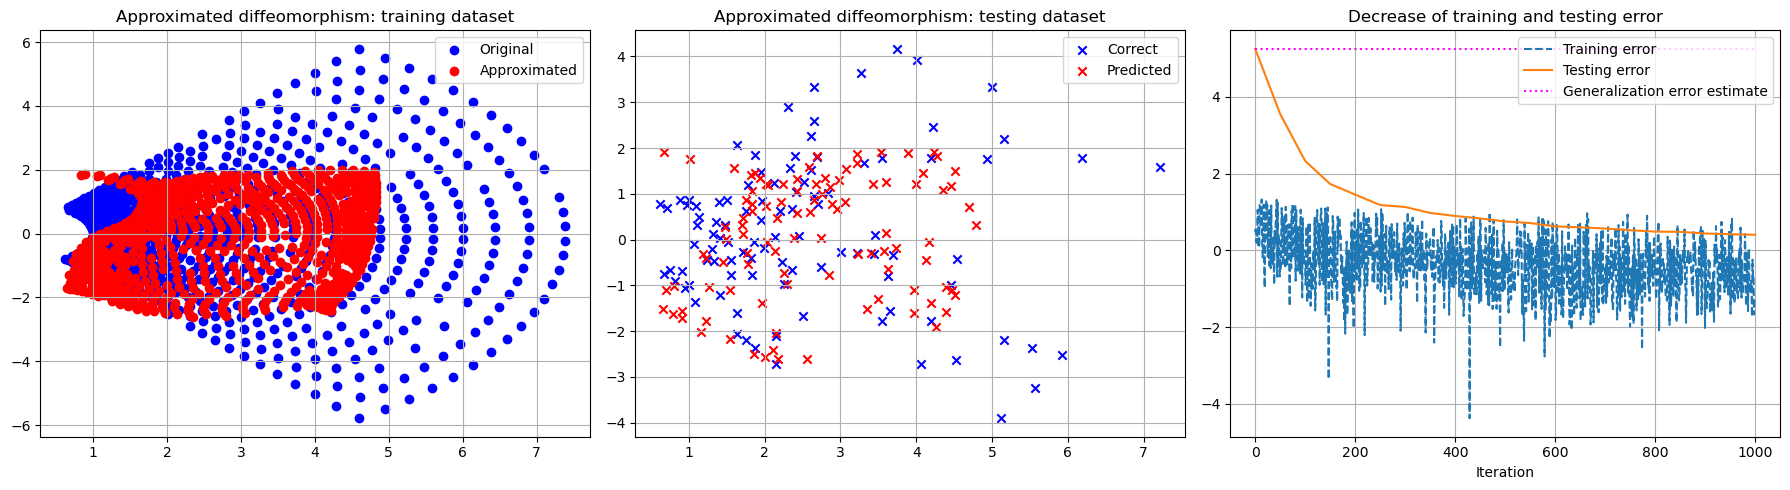

In [4]:
# Train fresh model for H = 0.2 (with correction)
H = 0.2
W_tensor = generate_fbm_weight_tensor(L, n, H=H)
model_corr = FBMResNet(2, n, L, H, W_tensor, apply_correction=True)
losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)

# Visualize diffeomorphism approximation for H = 0.2
plot_diffeomorphism_comparison(model_corr, X_train, Y_train, X_test, Y_test, losses_corr, test_corr, log_interval)


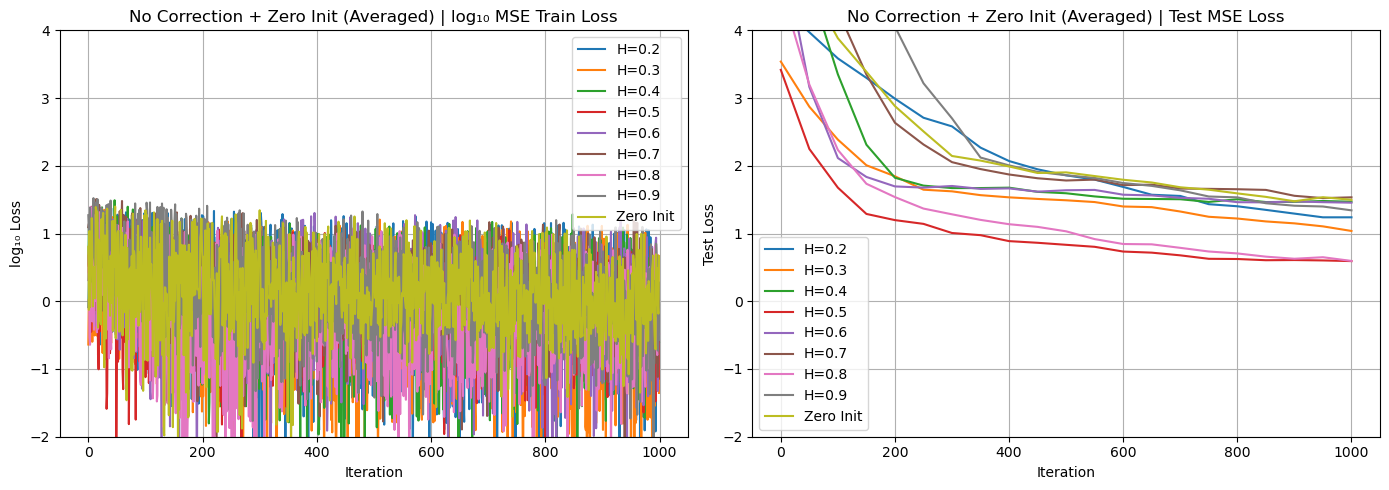

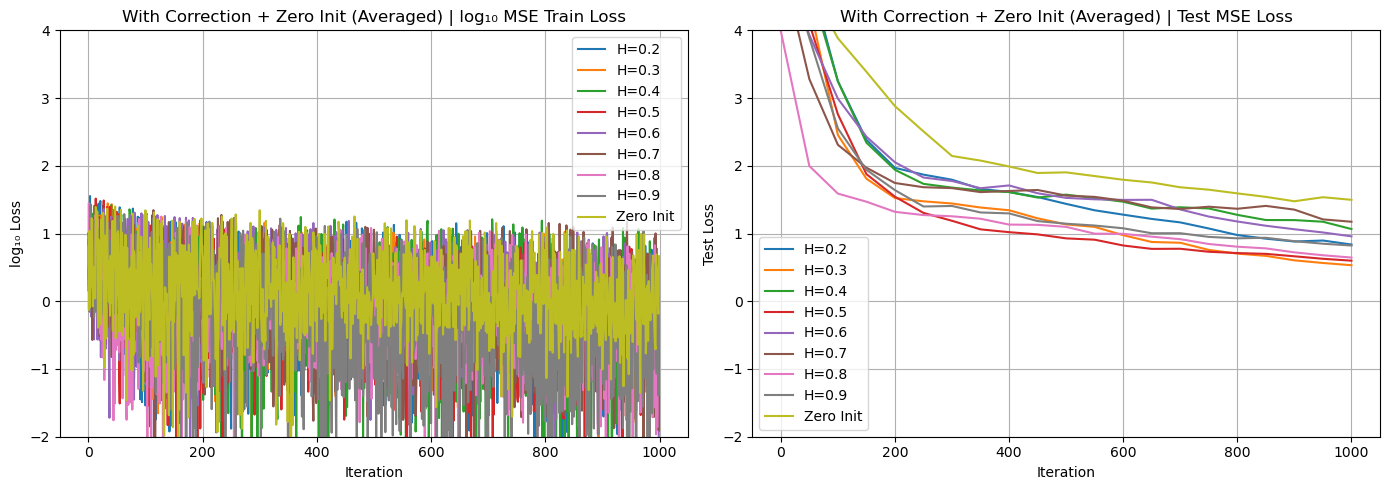

In [7]:
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for H, losses in sorted(train_loss_dict.items(), key=lambda x: str(x[0])):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].legend()
    axes[0].set_ylim([-2,4])
    axes[0].grid(True)

    for H, losses in sorted(test_loss_dict.items(), key=lambda x: str(x[0])):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].set_ylim([-2,4])
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_curves({**train_losses_nocorr, **train_losses_zero},
                 {**test_losses_nocorr, **test_losses_zero},
                 "No Correction + Zero Init (Averaged)", log_interval)

plot_loss_curves({**train_losses_corr, **train_losses_zero},
                 {**test_losses_corr, **test_losses_zero},
                 "With Correction + Zero Init (Averaged)", log_interval)


Averaging over runs: 100%|██████████| 1/1 [14:34<00:00, 874.93s/it]


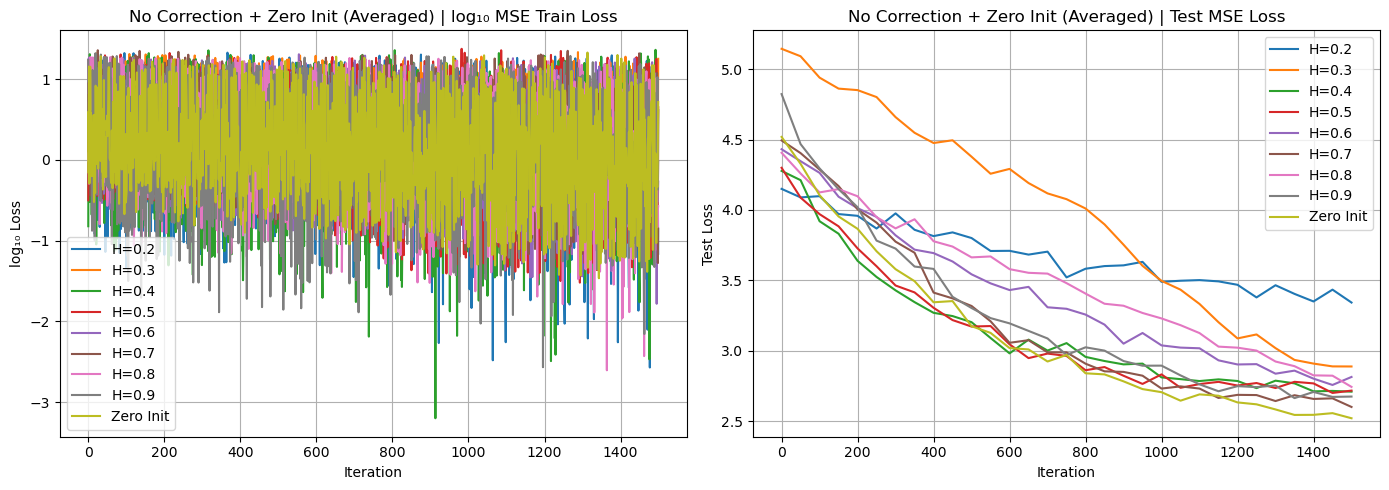

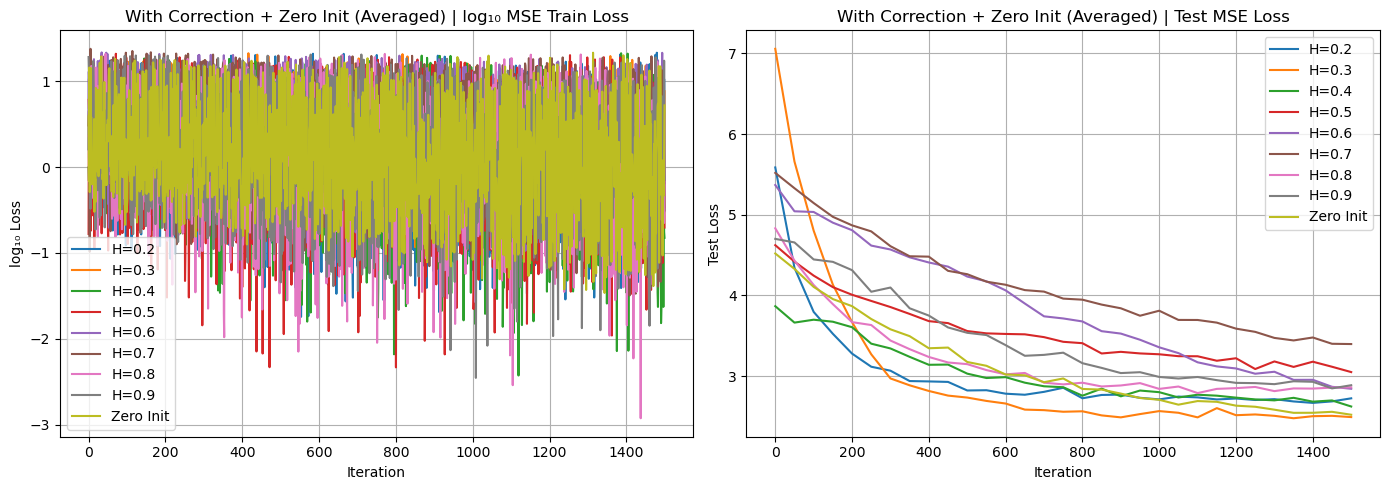

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ========== Synthetic Data ==========
def generate_transformed_dataset_3d():
    x1_vals = np.linspace(0, 2, 20)
    x2_vals = np.linspace(-0.9, 0.9, 20)
    x3_vals = np.linspace(0, 1, 20)
    X1, X2, X3 = np.meshgrid(x1_vals, x2_vals, x3_vals)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()
    X3_flat = X3.flatten()

    def psi(x1, x2, x3):
        r = np.exp(x1)
        y1 = r * np.cos(x2) * np.sin(np.pi * x3)
        y2 = r * np.sin(x2) * np.sin(np.pi * x3)
        y3 = r * np.cos(np.pi * x3)
        return y1, y2, y3

    Y1, Y2, Y3 = psi(X1_flat, X2_flat, X3_flat)
    X_np = np.stack([X1_flat, X2_flat, X3_flat], axis=1)
    Y_np = np.stack([Y1, Y2, Y3], axis=1)

    X = torch.tensor(X_np, dtype=torch.float32)
    Y = torch.tensor(Y_np, dtype=torch.float32)
    return X, Y


class TransformedDatasetLoader:
    def __init__(self, X, Y, batch_size=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            idx = torch.randint(0, self.X.shape[0], (self.batch_size,))
            yield self.X[idx], self.Y[idx]

# ========== FBM Generator ==========
def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

def generate_zero_weight_tensor(L, n):
    return torch.zeros((L, n, n), dtype=torch.float32)

# ========== FBM ResNet ==========
class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta * np.sqrt(W_k.size(0)))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift
        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out += correction
        return x + out

class FBMResNet(nn.Module):
    def __init__(self, input_dim, n, num_layers, beta, W_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, n)
        self.output_layer = nn.Linear(n, input_dim)
        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

# ========== Evaluation ==========
@torch.no_grad()
def evaluate_on_test(model, test_loader, criterion, max_batches=200):
    model.eval()
    total_loss = 0.0
    num_samples = 0
    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i >= max_batches:
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)
        num_samples += x_batch.size(0)
    return total_loss / num_samples

# ========== Training ==========
def train_single_point_model(model, train_loader, test_loader, epochs=300, lr=0.01, log_interval=50):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if i % log_interval == 0 or i == epochs - 1:
            test_loss = evaluate_on_test(model, test_loader, criterion)
            test_losses.append(test_loss)

        if i >= epochs - 1:
            break
    return train_losses, test_losses

# ========== Plotting ==========
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for H, losses in sorted(train_loss_dict.items(), key=lambda x: str(x[0])):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].legend()
    axes[0].grid(True)

    for H, losses in sorted(test_loss_dict.items(), key=lambda x: str(x[0])):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ========== Experiment ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
L = 500
n = 3
epochs = 1500
log_interval = 50
n_runs = 1

train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}
test_losses_corr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
test_losses_nocorr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
train_losses_zero = {"zero": np.zeros(epochs)}
test_losses_zero = {"zero": np.zeros(epochs // log_interval + 1)}

# Dataset
X, Y = generate_transformed_dataset_3d()
# For 4D, just extend the dataset generator similarly

X_train, Y_train = X[perm[:800]], Y[perm[:800]]
X_test, Y_test = X[perm[800:]], Y[perm[800:]]

train_loader = TransformedDatasetLoader(X_train.to(device), Y_train.to(device), batch_size=1)
test_loader = TransformedDatasetLoader(X_test.to(device), Y_test.to(device), batch_size=64)


# Main loop
for run in tqdm(range(n_runs), desc="Averaging over runs"):
    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)

        # No correction
        model_nocorr = FBMResNet(3, n, L, H, W_tensor, apply_correction=False)
        losses_nocorr, test_nocorr = train_single_point_model(model_nocorr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_nocorr[H] += np.array(losses_nocorr)
        test_losses_nocorr[H] += np.array(test_nocorr)

        # With correction
        model_corr = FBMResNet(3, n, L, H, W_tensor, apply_correction=True)
        losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_corr[H] += np.array(losses_corr)
        test_losses_corr[H] += np.array(test_corr)

    # === Zero Init ===
    W_tensor_zero = generate_zero_weight_tensor(L, n)
    model_zero = FBMResNet(3, n, L, beta=0.5, W_tensor=W_tensor_zero, apply_correction=False)
    losses_zero, test_zero = train_single_point_model(model_zero, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
    train_losses_zero["zero"] += np.array(losses_zero)
    test_losses_zero["zero"] += np.array(test_zero)

# Average
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    test_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs
    test_losses_corr[H] /= n_runs

train_losses_zero["zero"] /= n_runs
test_losses_zero["zero"] /= n_runs

# Plot
plot_loss_curves({**train_losses_nocorr, **train_losses_zero},
                 {**test_losses_nocorr, **test_losses_zero},
                 "No Correction + Zero Init (Averaged)", log_interval)

plot_loss_curves({**train_losses_corr, **train_losses_zero},
                 {**test_losses_corr, **test_losses_zero},
                 "With Correction + Zero Init (Averaged)", log_interval)

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot_diffeomorphism_comparison_3d(model, X_train, Y_train, X_test, Y_test, train_loss, test_loss, log_interval):
    model.eval()
    with torch.no_grad():
        pred_train = model(X_train.to(device)).cpu()
        pred_test = model(X_test.to(device)).cpu()

    fig = plt.figure(figsize=(18, 5))

    # === Left: Training dataset ===
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(*Y_train.T.numpy(), color='blue', label='Original')
    ax1.scatter(*pred_train.T.numpy(), color='red', label='Approximated')
    ax1.set_title("Training diffeomorphism")
    ax1.legend()

    # === Middle: Test dataset ===
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(*Y_test.T.numpy(), color='blue', label='Ground Truth')
    ax2.scatter(*pred_test.T.numpy(), color='red', label='Predicted')
    ax2.set_title("Test diffeomorphism")
    ax2.legend()

    # === Right: Loss ===
    ax3 = fig.add_subplot(133)
    ax3.plot(np.log10(train_loss), label='Train Loss', linestyle='--')
    ax3.plot(np.arange(len(test_loss)) * log_interval, test_loss, label='Test Loss')
    ax3.set_title("Loss Curves")
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()


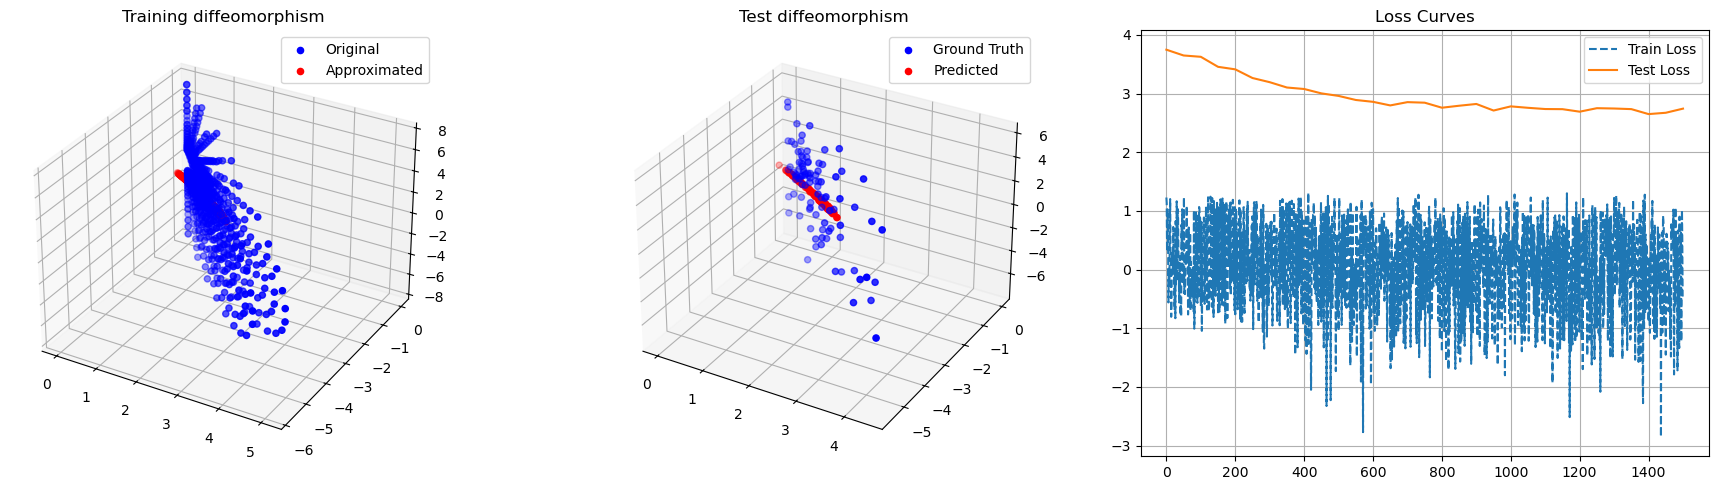

In [10]:
# Train fresh model for H = 0.2 (with correction)
H = 0.2
W_tensor = generate_fbm_weight_tensor(L, n, H=H)
model_corr = FBMResNet(3, n, L, H, W_tensor, apply_correction=True)
losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)

# Visualize diffeomorphism approximation for H = 0.2
plot_diffeomorphism_comparison_3d(model_corr, X_train, Y_train, X_test, Y_test, losses_corr, test_corr, log_interval)


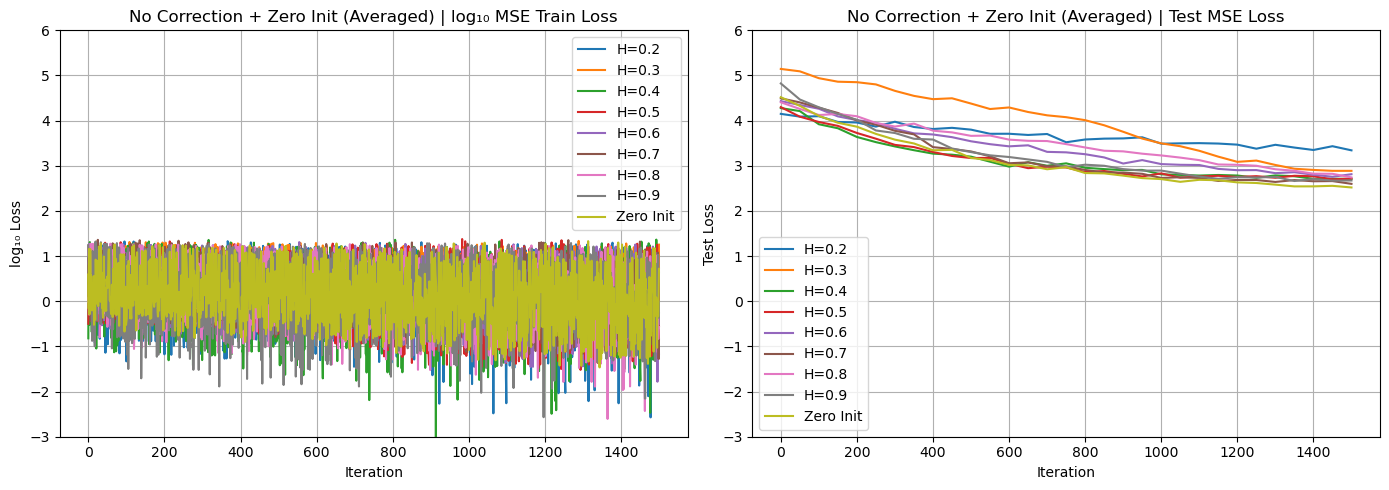

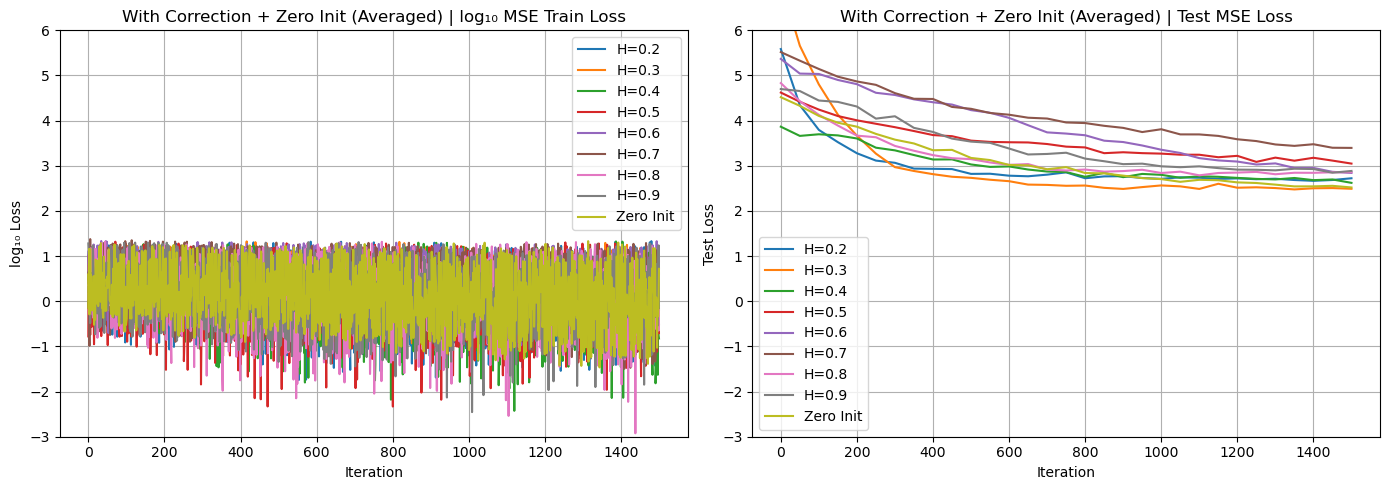

In [12]:
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for H, losses in sorted(train_loss_dict.items(), key=lambda x: str(x[0])):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].legend()
    axes[0].set_ylim([-3,6])
    axes[0].grid(True)

    for H, losses in sorted(test_loss_dict.items(), key=lambda x: str(x[0])):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}" if isinstance(H, float) else "Zero Init")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].set_ylim([-3,6])
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_curves({**train_losses_nocorr, **train_losses_zero},
                 {**test_losses_nocorr, **test_losses_zero},
                 "No Correction + Zero Init (Averaged)", log_interval)

plot_loss_curves({**train_losses_corr, **train_losses_zero},
                 {**test_losses_corr, **test_losses_zero},
                 "With Correction + Zero Init (Averaged)", log_interval)


Averaging over runs: 100%|██████████| 10/10 [35:38<00:00, 213.83s/it]


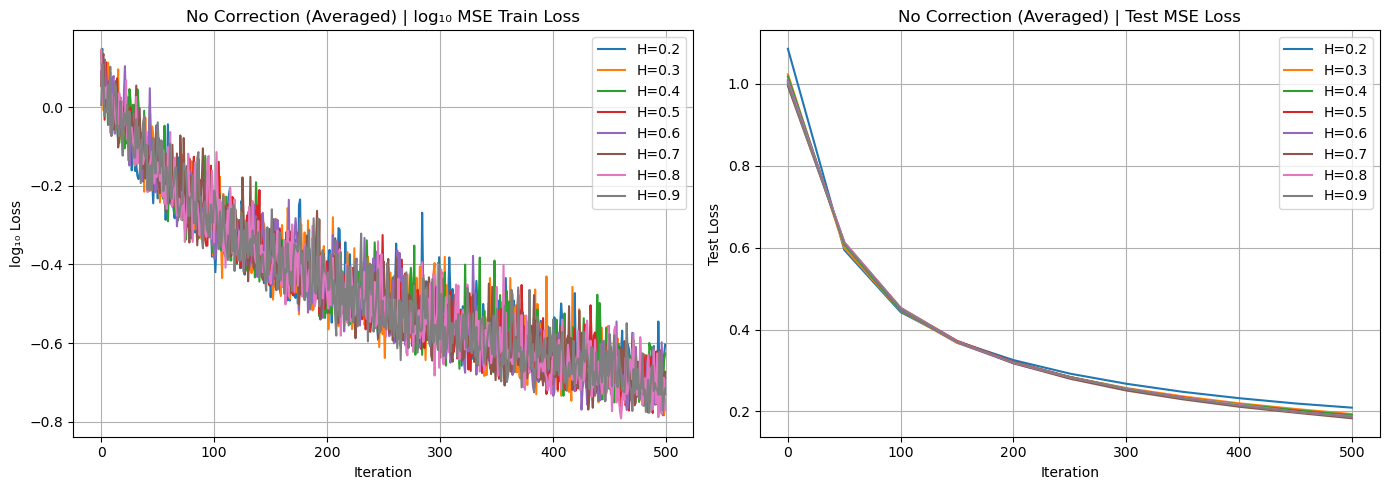

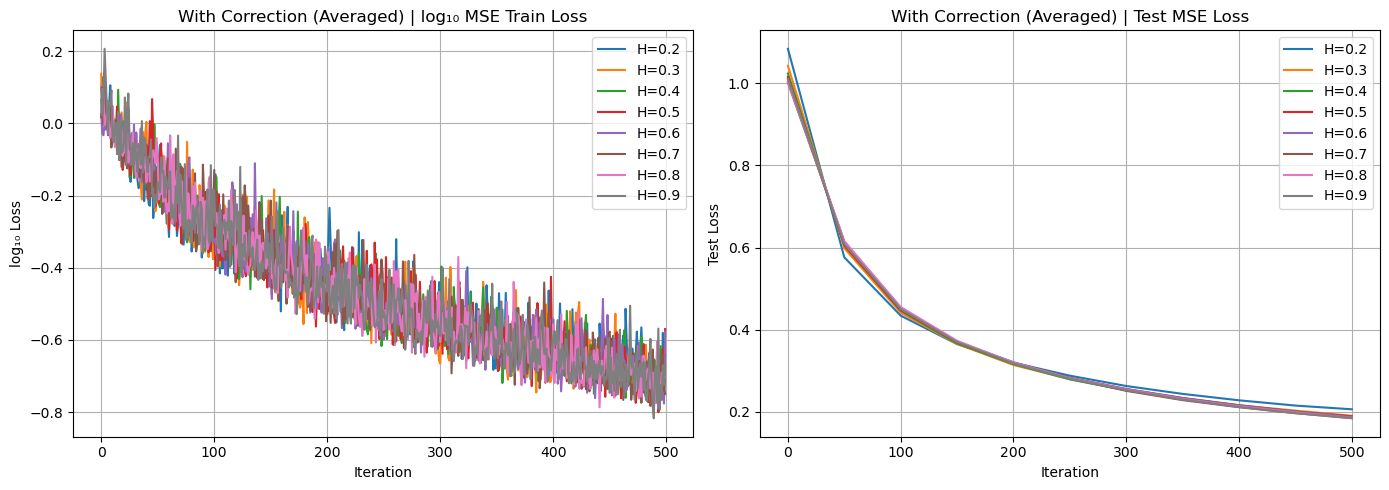

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# ========== Load Digits Dataset ==========
def load_digit_dataset():
    digits = load_digits()
    X = digits.data
    y = digits.data  # same as X for autoencoding

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    return X_train, X_test

class DigitsDatasetLoader:
    def __init__(self, X, batch_size=1):
        self.X = X
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            idx = torch.randint(0, self.X.shape[0], (self.batch_size,))
            yield self.X[idx], self.X[idx]

# ========== FBM Generator ==========
def generate_fbm_path(H, L):
    t = np.linspace(0, 1, L + 1)
    cov = 0.5 * (np.add.outer(t**(2*H), t**(2*H)) - np.abs(np.subtract.outer(t, t))**(2*H))
    L_chol = np.linalg.cholesky(cov + 1e-10 * np.eye(L + 1))
    Z = np.random.randn(L + 1)
    return L_chol @ Z

def generate_fbm_weight_tensor(L, n, H):
    W = np.zeros((L, n, n))
    for i in range(n):
        for j in range(n):
            fbm_path = generate_fbm_path(H, L)
            increments = np.diff(fbm_path)
            W[:, i, j] = (L**H) * increments
    return torch.tensor(W, dtype=torch.float32)

# ========== FBM ResNet ==========
class FBMResidualBlock(nn.Module):
    def __init__(self, W_k, beta, L, apply_correction=True, C_H=0.5):
        super().__init__()
        self.W = nn.Parameter(W_k, requires_grad=False)
        self.beta = beta
        self.L = L
        self.C_H = C_H
        self.apply_correction = apply_correction
        self.scale = 1.0 / (L ** beta * np.sqrt(W_k.size(0)))

    def forward(self, x):
        sigma = torch.tanh(x)
        drift = F.linear(sigma, self.W)
        out = self.scale * drift

        if self.apply_correction:
            sigma_prime = 1 - sigma**2
            correction = (self.scale**2) * self.C_H * (sigma * sigma_prime)
            out = out + correction

        return x + out

class FBMResNet(nn.Module):
    def __init__(self, input_dim, n, num_layers, beta, W_tensor, apply_correction=True):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, n)
        self.output_layer = nn.Linear(n, input_dim)
        self.blocks = nn.ModuleList([
            FBMResidualBlock(W_tensor[k], beta, num_layers, apply_correction)
            for k in range(num_layers)
        ])

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

# ========== Evaluation ==========
@torch.no_grad()
def evaluate_on_test(model, test_loader, criterion, max_batches=200):
    model.eval()
    total_loss = 0.0
    num_samples = 0

    for i, (x_batch, y_batch) in enumerate(test_loader):
        if i >= max_batches:
            break
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        total_loss += loss.item() * x_batch.size(0)
        num_samples += x_batch.size(0)

    return total_loss / num_samples

# ========== Training ==========
def train_single_point_model(model, train_loader, test_loader, epochs=300, lr=0.01, log_interval=50):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        model.train()
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if i % log_interval == 0 or i == epochs - 1:
            test_loss = evaluate_on_test(model, test_loader, criterion)
            test_losses.append(test_loss)

        if i >= epochs - 1:
            break

    return train_losses, test_losses

# ========== Plotting ==========
def plot_loss_curves(train_loss_dict, test_loss_dict, label_prefix, log_interval):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Train Loss
    for H, losses in sorted(train_loss_dict.items()):
        axes[0].plot(np.log10(losses), label=f"H={H:.1f}")
    axes[0].set_title(f"{label_prefix} | log₁₀ MSE Train Loss")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("log₁₀ Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Test Loss
    for H, losses in sorted(test_loss_dict.items()):
        axes[1].plot(np.arange(len(losses)) * log_interval, losses, label=f"H={H:.1f}")
    axes[1].set_title(f"{label_prefix} | Test MSE Loss")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Test Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ========== Experiment ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_H = [0.9,0.8, 0.7,0.6, 0.5,0.4, 0.3,0.2]
L = 100
n = 64
epochs = 500
log_interval = 50
n_runs = 10

train_losses_corr = {H: np.zeros(epochs) for H in selected_H}
train_losses_nocorr = {H: np.zeros(epochs) for H in selected_H}
test_losses_corr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}
test_losses_nocorr = {H: np.zeros(epochs // log_interval + 1) for H in selected_H}

X_train, X_test = load_digit_dataset()
train_loader = DigitsDatasetLoader(X_train.to(device), batch_size=32)
test_loader = DigitsDatasetLoader(X_test.to(device), batch_size=256)

# Main loop
for run in tqdm(range(n_runs), desc="Averaging over runs"):
    for H in selected_H:
        W_tensor = generate_fbm_weight_tensor(L, n, H=H)

        # No correction
        model_nocorr = FBMResNet(64, n, L, H, W_tensor, apply_correction=False)
        losses_nocorr, test_nocorr = train_single_point_model(model_nocorr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_nocorr[H] += np.array(losses_nocorr)
        test_losses_nocorr[H] += np.array(test_nocorr)

        # With correction
        model_corr = FBMResNet(64, n, L, H, W_tensor, apply_correction=True)
        losses_corr, test_corr = train_single_point_model(model_corr, train_loader, test_loader, epochs=epochs, lr=0.1 * n / L, log_interval=log_interval)
        train_losses_corr[H] += np.array(losses_corr)
        test_losses_corr[H] += np.array(test_corr)

# Average
for H in selected_H:
    train_losses_nocorr[H] /= n_runs
    test_losses_nocorr[H] /= n_runs
    train_losses_corr[H] /= n_runs
    test_losses_corr[H] /= n_runs

# Plot
plot_loss_curves(train_losses_nocorr, test_losses_nocorr, "No Correction (Averaged)", log_interval)
plot_loss_curves(train_losses_corr, test_losses_corr, "With Correction (Averaged)", log_interval)
